In [281]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10 # увеличиваем размер картинок
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность

In [5]:
data = pd.read_csv('data/train.csv.gz', compression='gzip', delimiter=';', index_col='id')
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
def get_X(df):
    return df.drop(['cardio'], axis=1)

def get_Y(df):
    return df['cardio']

In [10]:
def examine(clf, df, random_state=42, scoring='neg_log_loss'):
    X, y = get_X(df), get_Y(df) 
    folds = KFold(n_splits=5, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=folds, scoring=scoring)
    print("Log Loss: {}, std: {}".format(scores.mean(), 2 * scores.std())) 

In [232]:
from sklearn.metrics import make_scorer, log_loss
log_loss_score = make_scorer(log_loss, greater_is_better=False)

In [205]:
def examine_scaled(clf, df, random_state=42, scoring='neg_log_loss'):
    X, y = get_X(df), get_Y(df)
    X = StandardScaler().fit_transform(X)
    folds = KFold(n_splits=5, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=folds, scoring=scoring)
    print("Log Loss: {}, std: {}".format(scores.mean(), 2 * scores.std())) 

In [250]:
def describeImportance(clf, X):
    indices = np.argsort(clf.feature_importances_)[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f + 1, indices[f], X.columns[indices[f]],
                                          clf.feature_importances_[indices[f]]))
        
def describeCoef(clf, X):
    coefs = clf.coef_
    indices = np.argsort(np.abs(coefs))[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f, indices[f], X.columns[indices[f]], coefs[indices[f]]))

In [200]:
clf = LogisticRegression(n_jobs=4, random_state=42)
examine(clf, data)

Log Loss: -0.5910060857202228, std: 0.0034394317828089467


In [12]:
clf = XGBClassifier(seed=42, nthread=4)
examine(clf, data,scoring='roc_auc')

Log Loss: 0.802674118440394, std: 0.0055083072780918365


In [17]:
clf = XGBClassifier(seed=42, nthread=4)
examine(clf, data)

Log Loss: -0.5396301910766, std: 0.005472783959989331


In [14]:
clf = DummyClassifier()
examine(clf, data)

Log Loss: -17.278269597099744, std: 0.10291377356163346


In [42]:
data[data['height'] > 200]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
9223,21220,1,250,86.0,140,100,3,1,0,0,1,1
30894,19054,2,207,78.0,100,70,1,1,0,1,1,0


In [67]:
data[(data['height'] < 100) & (data['weight'] >= 100)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
11662,17646,2,97,170.0,160,100,1,1,1,0,1,1
18218,19594,1,75,168.0,120,80,1,1,1,0,1,1
34186,19074,1,81,156.0,140,90,1,1,0,0,1,0
39156,15292,1,80,178.0,140,90,3,3,0,0,1,1


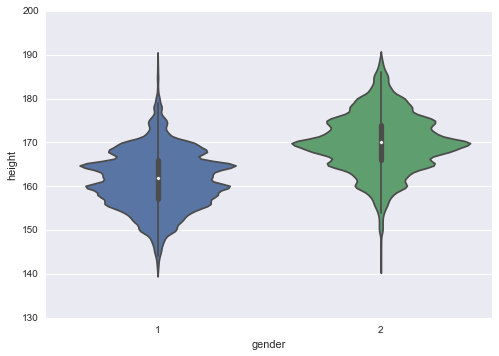

In [57]:
sns.violinplot(y='height', x='gender', data=data[(data['height'] < 190) & (data['height'] > 140)])

In [355]:
def prepare(df):
    df = df.copy()
    df['age'] = df['age'] // 365.25
    df['ap_hi'] = np.abs(df['ap_hi'])
    df['ap_lo'] = np.abs(df['ap_lo'])
    df.loc[df['ap_hi'] >= 5000, 'ap_hi'] /= 100
    df.loc[df['ap_hi'] >= 300, 'ap_hi'] /= 10
    df.loc[df['ap_hi'] <= 20, 'ap_hi'] *= 10
    df.loc[df['ap_hi'] <= 20, 'ap_hi'] *= 10
    df.loc[df['ap_lo'] >= 5000, 'ap_lo'] /= 100
    df.loc[df['ap_lo'] >= 300, 'ap_lo'] /= 10
    df.loc[df['ap_lo'] <= 20, 'ap_lo'] *= 10
    df.loc[df['ap_lo'] <= 20, 'ap_lo'] *= 10
    df.loc[df['ap_lo'] < 1, 'ap_lo'] = 70
    
    index = (df['ap_lo'] > df['ap_hi'])
    ap_lo = df.loc[index, 'ap_lo']
    ap_hi = df.loc[index, 'ap_hi']
    df.loc[index, 'ap_hi'] = ap_lo
    df.loc[index, 'ap_lo'] = ap_hi
    
    df['ap_delta'] = np.abs(df['ap_hi'] - df['ap_lo'])
    df['ap_avg'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
    df.loc[df['height'] > 210, 'height'] -= 100
    df.loc[(df['height'] < 100) & (df['weight'] < 100), 'height'] += 100
    
    index = (df['height'] < 100) & (df['weight'] >= 100)
    h = df.loc[index, 'height']
    w = df.loc[index, 'weight']
    df.loc[index, 'height'] = w
    df.loc[index, 'weight'] = h
    
    df['imt'] = df['weight'] / ((df['height'] / 100.0) ** 2)
    
    df['4*ch+gl'] = 4 * df['cholesterol'] + df['gluc']
    df['w-h+100'] = df['weight'] - (df['height'] - 105)
    
    #df = pd.get_dummies(df, columns=['gender', 'cholesterol', 'gluc'])
    ch_labels = df.groupby(by='cholesterol')['ap_avg'].median()
    df['cholesterol-ap_avg'] = df['cholesterol'].apply(lambda e: ch_labels[e])

    alco_labels = df.groupby(by='alco')['ap_avg'].median()
    df['alco-ap_avg'] = df['alco'].apply(lambda e: alco_labels[e])
    
    smoke_labels = df.groupby(by='smoke')['ap_avg'].median()
    df['smoke-ap_avg'] = df['smoke'].apply(lambda e: smoke_labels[e])
    
    return df#.drop(['smoke', 'alco', 'gender', 'cholesterol', 'height', 'weight'], axis=1)


d = prepare(data)
d.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_delta,ap_avg,imt,4*ch+gl,w-h+100,cholesterol-ap_avg,alco-ap_avg,smoke-ap_avg
id,,,,,,,,,,,,,,,,,,,,
0,50.0,2,168.0,62.0,110.0,80.0,1,1,0,0,1,0,30.0,90.000000,21.967120,5,-1.0,93.333333,93.333333,93.333333
1,55.0,1,156.0,85.0,140.0,90.0,3,1,0,0,1,1,50.0,106.666667,34.927679,13,34.0,100.000000,93.333333,93.333333
2,51.0,1,165.0,64.0,130.0,70.0,3,1,0,0,0,1,60.0,90.000000,23.507805,13,4.0,100.000000,93.333333,93.333333
3,48.0,2,169.0,82.0,150.0,100.0,1,1,0,0,1,1,50.0,116.666667,28.710479,5,18.0,93.333333,93.333333,93.333333
4,47.0,1,156.0,56.0,100.0,60.0,1,1,0,0,0,0,40.0,73.333333,23.011177,5,5.0,93.333333,93.333333,93.333333


In [352]:
d.describe()

,age,ap_hi,ap_lo,gluc,active,cardio,ap_delta,ap_avg,imt,4*ch+gl,w-h+100,cholesterol-ap_avg,alco-ap_avg,smoke-ap_avg
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04
mean,52.803257,127.082957,81.589693,1.226457,0.803729,0.499700,45.493265,96.754114,27.502504,6.693943,14.802490,94.556238,93.512571,9.333333e+01
std,6.762462,17.084971,9.779714,0.572270,0.397179,0.500003,11.827921,11.400517,5.376493,3.022861,14.197317,2.267501,0.751892,1.421096e-14
min,29.000000,60.000000,24.000000,1.000000,0.000000,0.000000,0.000000,43.933333,3.471784,5.000000,-62.000000,93.333333,93.333333,9.333333e+01
25%,48.000000,120.000000,80.000000,1.000000,1.000000,0.000000,40.000000,93.333333,23.875115,5.000000,5.000000,93.333333,93.333333,9.333333e+01
50%,53.000000,120.000000,80.000000,1.000000,1.000000,0.000000,40.000000,93.333333,26.370238,5.000000,12.000000,93.333333,93.333333,9.333333e+01
75%,58.000000,140.000000,90.000000,1.000000,1.000000,1.000000,50.000000,103.333333,30.189591,9.000000,23.000000,96.666667,93.333333,9.333333e+01
max,64.000000,240.000000,182.000000,3.000000,1.000000,1.000000,176.000000,186.666667,152.551775,15.000000,166.000000,100.000000,96.666667,9.333333e+01


In [356]:
#0.5388282655108321
clf = XGBClassifier(seed=42, nthread=4, n_estimators=100, max_depth=5)
examine(clf, d)

Log Loss: -0.5389489934857934, std: 0.005761162955079725


In [279]:
#0.5588693851971233
clf = LogisticRegression(n_jobs=4, random_state=42)
examine_scaled(clf, d)

Log Loss: -0.5586246407040302, std: 0.003914658248574603


In [262]:
clf = Lasso(normalize=True, alpha=0.0000001)
examine_scaled(clf, d, scoring=log_loss_score)
clf.fit(get_X(d), get_Y(d))
describeCoef(clf, get_X(d))

Log Loss: -0.7228112118128941, std: 0.030038796871441568
0. feature 14 cholesterol_3 (0.120214)
1. feature 12 cholesterol_1 (-0.081424)
2. feature 17 gluc_3 (-0.054687)
3. feature 7 active (-0.043336)
4. feature 6 alco (-0.039345)
5. feature 5 smoke (-0.025168)
6. feature 0 age (0.010272)
7. feature 3 ap_hi (0.009616)
8. feature 9 imt (-0.004514)
9. feature 2 weight (0.003875)
10. feature 10 gender_1 (0.002972)
11. feature 1 height (-0.002466)
12. feature 4 ap_lo (0.002400)
13. feature 13 cholesterol_2 (-0.001385)
14. feature 15 gluc_1 (0.001193)
15. feature 11 gender_2 (-0.000000)
16. feature 16 gluc_2 (-0.000000)
17. feature 8 delta_ap (0.000000)


In [268]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5,3))
examine_scaled(clf, d)

Log Loss: -0.5418088152912676, std: 0.0034561504159370906


In [78]:
train = prepare(pd.read_csv('data/train.csv.gz', compression='gzip', delimiter=';', index_col='id'))
test = prepare(pd.read_csv('data/test.csv.gz', compression='gzip', delimiter=';', index_col='id'))

clf = XGBClassifier(seed=42, nthread=4, n_estimators=1000)
clf.fit(get_X(train), get_Y(train))
pred = clf.predict_proba(test)

result = pd.DataFrame(index=test.index)
result['cardio'] = pred[:, 1]
result.to_csv('submission_baseline_1.csv', header=None, index=None)

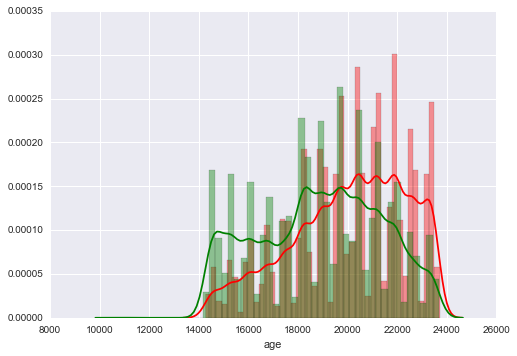

In [32]:
# sns.distplot(data['age'])
sns.distplot(data[data['cardio'] == 1]['age'], color='red')
sns.distplot(data[data['cardio'] != 1]['age'], color='green')

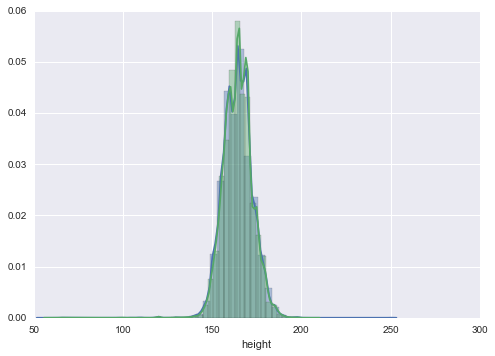

In [107]:
sns.distplot(data[data['cardio'] == 1]['height'])
sns.distplot(data[data['cardio'] != 1]['height'])

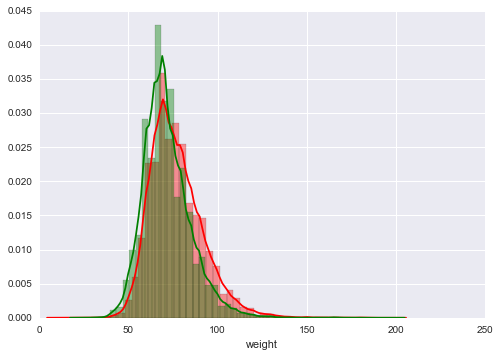

In [115]:
sns.distplot(d[d['cardio'] == 1]['weight'], color='red')
sns.distplot(d[d['cardio'] != 1]['weight'], color='green')

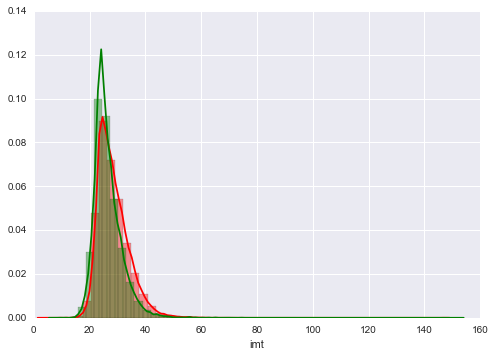

In [114]:
sns.distplot(d[(d['cardio'] == 1)]['imt'], color='red')
sns.distplot(d[(d['cardio'] == 0)]['imt'], color='green')

1
16020


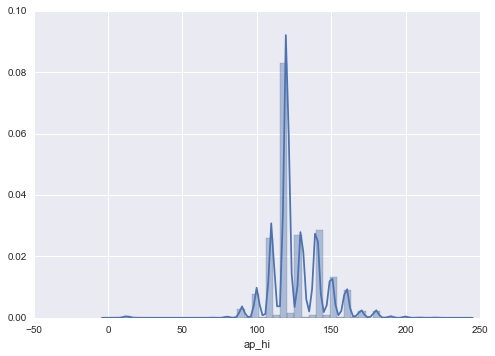

In [116]:
print(d['ap_hi'].min())
print(d['ap_hi'].max())
sns.distplot(d[d['ap_hi'] < 250]['ap_hi'])

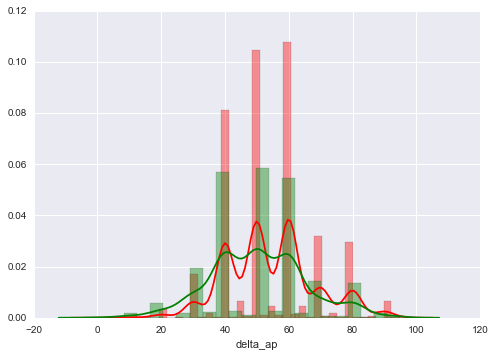

In [126]:
sns.distplot(d[(d['cardio'] == 1) & (d['delta_ap'] < 100) & (d['ap_lo'] > 90)]['delta_ap'], color='red')
sns.distplot(d[(d['cardio'] == 0) & (d['delta_ap'] < 100) & (d['ap_lo'] > 90)]['delta_ap'], color='green')

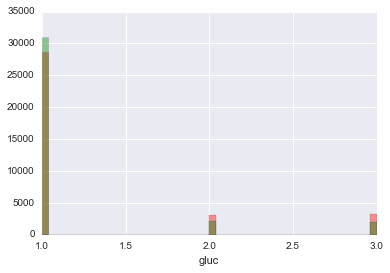

In [271]:
sns.distplot(data[(data['cardio'] == 1)]['gluc'], color='red', kde=False)
sns.distplot(data[(data['cardio'] == 0)]['gluc'], color='green', kde=False)

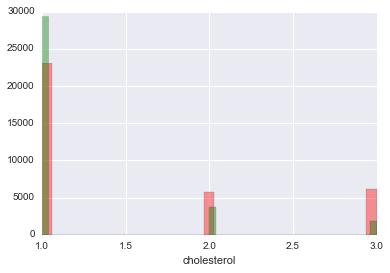

In [272]:
sns.distplot(data[(data['cardio'] == 1)]['cholesterol'], color='red', kde=False)
sns.distplot(data[(data['cardio'] == 0)]['cholesterol'], color='green', kde=False)

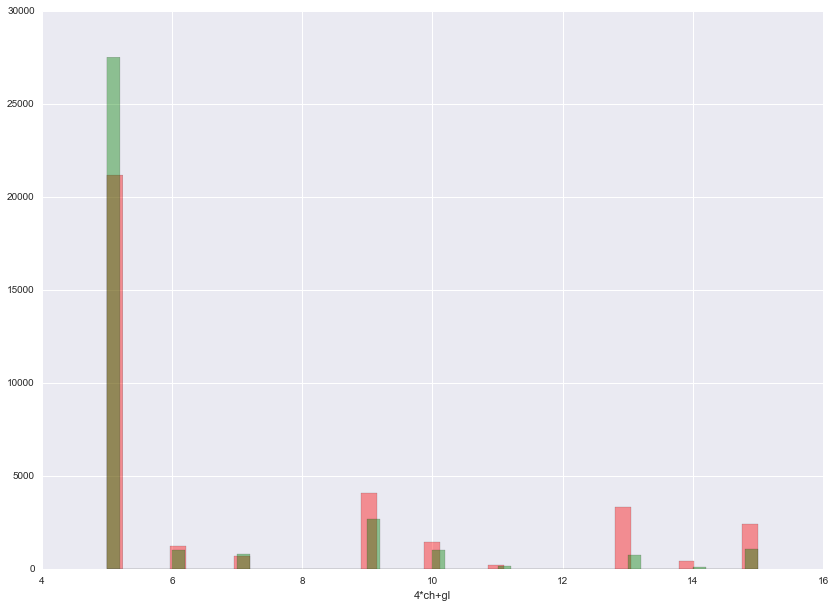

In [282]:
d2 = data.copy()
d2['4*ch+gl'] = 4 * d2['cholesterol'] + d2['gluc']

sns.distplot(d2[(d2['cardio'] == 1)]['4*ch+gl'], color='red', kde=False)
sns.distplot(d2[(d2['cardio'] == 0)]['4*ch+gl'], color='green', kde=False)

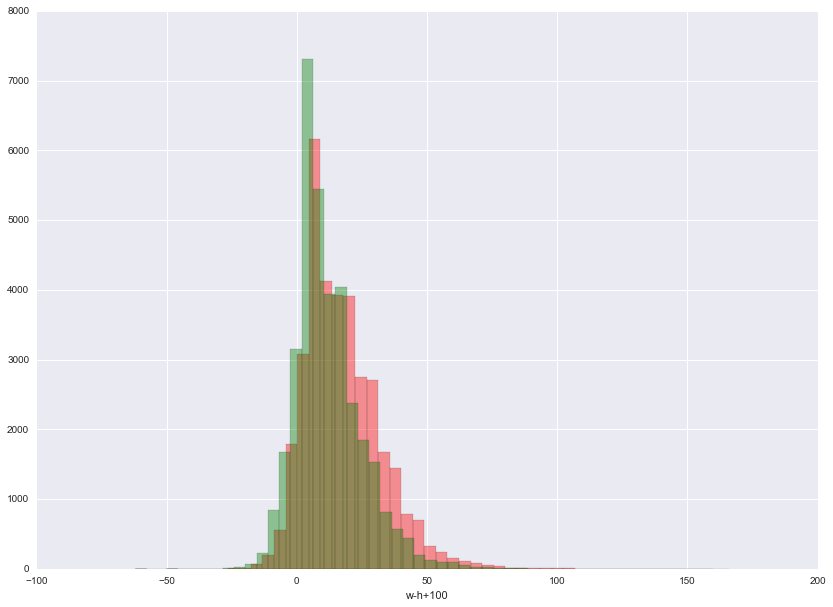

In [307]:
d2 = d.copy()
d2['w-h+100'] = d2['weight'] - (d2['height'] - 105)

sns.distplot(d2[(d2['cardio'] == 1)]['w-h+100'], color='red', kde=False)
sns.distplot(d2[(d2['cardio'] == 0)]['w-h+100'], color='green', kde=False)

In [309]:
def scatter(df, x, y):
    plt.scatter(df[(df['cardio'] == 1)][x], df[(df['cardio'] == 1)][y], color='red', alpha=0.5)
    plt.scatter(df[(df['cardio'] == 0)][x], df[(df['cardio'] == 0)][y], color='green', alpha=0.5)

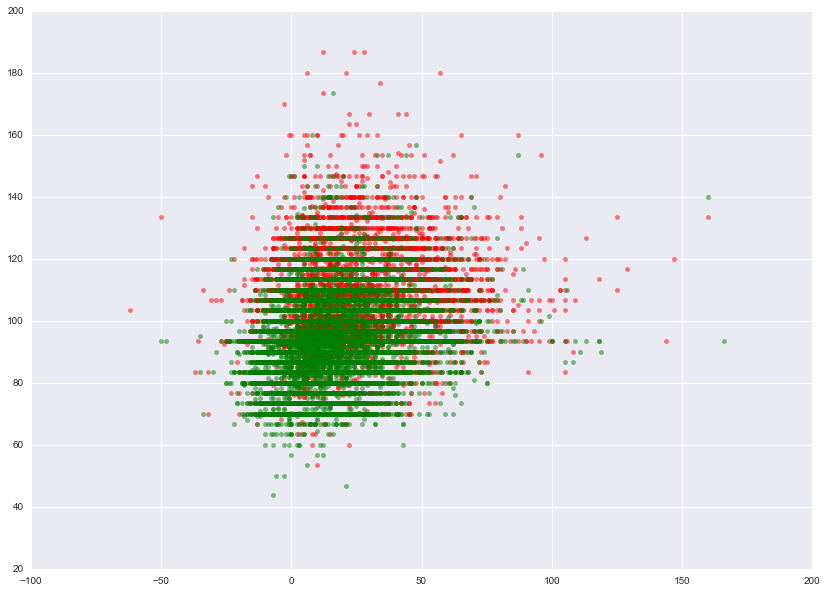

In [312]:
scatter(d2, 'w-h+100', 'ap_avg')

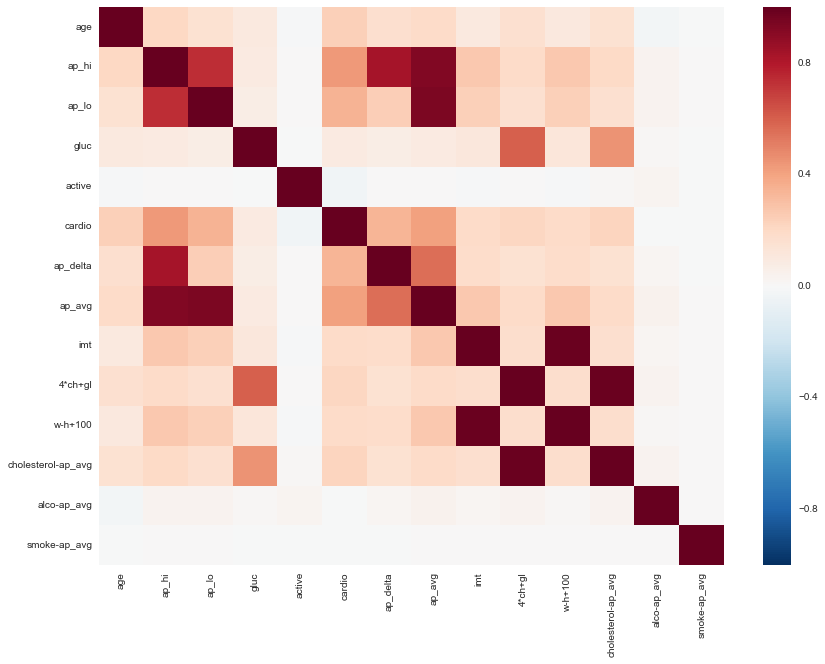

In [353]:
d2 = d.copy()
d2['cardio'] = data['cardio']
sns.heatmap(d2.corr())

In [347]:
# d.groupby(by='cholesterol')['ap_avg'].median()
d.groupby(by='smoke')['ap_avg'].mean()

smoke
0    96.652338
1    97.807198
Name: ap_avg, dtype: float64